The log files that I used for this assignment are in the Apache Common Log Format (CLF). The log file entries produced in CLF will look something like this:
127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839


Each part of the log is described below

127.0.0.1- It is the IP address of the client
[01/Aug/1995:00:00:01 -0400] - The day and time when the request was made
"GET /images/launch-logo.gif HTTP/1.0"- The type of request made(GET or POST) and the url of the resource.
200- The status of the request
1839- The size of the object returned to the client not including the headers

In [5]:
import re
import datetime

from pyspark.sql import Row

# A regular expression pattern to extract fields from the log line
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

Creating the initial RDDs

Creating a function to parse the log lines. We'll be caching those RDD in memory throughout this notebook. 

In [15]:
import sys
import os

logFile = os.path.abspath('/home/aditya/Desktop/Aditya/bigdata/pyspark/access_log_Jul95')

def parseLogs():
    """ Read and parse log file """
    parsedLogs=sc.textFile(logFile).map(parseApacheLogLine).cache()
    accessLogs=parsedLogs.filter(lambda s:s[1]==1).map(lambda s:s[0]).cache()
    failedLogs=parsedLogs.filter(lambda s:s[1]==0).map(lambda s:s[0]).cache()
    
    print parsedLogs.count()
    print 'Read %d lines, parsed %d file sucessfully, failed to parse %d ' % (parsedLogs.count(),accessLogs.count()
                                                                              ,failedLogs.count())
    return parsedLogs,accessLogs,failedLogs


parsed_logs,access_logs,failed_logs=parseLogs()

1891715
Read 1891715 lines, parsed 1890851 file sucessfully, failed to parse 864 


Calculate statistics based on the content size.

In [16]:
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print 'Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max())

Content Size Avg: 20464, Min: 0, Max: 6823936


Response code Analysis. Counting the number of response code for each type

In [21]:
responseCodeCount=access_logs.map(lambda log:(log.response_code,1)).reduceByKey(lambda a,b:a+b).cache()
responseCodeToCountList = responseCodeCount.take(100)

print responseCodeToCountList

[(302, 46569), (304, 132626), (500, 62), (200, 1700743), (403, 54), (501, 14), (404, 10783)]


Now lets visualize the results of the response codes using matplotlib

In [23]:
labels = responseCodeCount.map(lambda (x, y): x).collect()
print labels
count = access_logs.count()
fracs = responseCodeCount.map(lambda (x, y): (float(y) / count)).collect()
print fracs

[302, 304, 500, 200, 403, 501, 404]
[0.024628593157260938, 0.07014090480952756, 3.278946886877919e-05, 0.8994590266499053, 2.8558569659904456e-05, 7.404073615530785e-06, 0.005702723271162033]


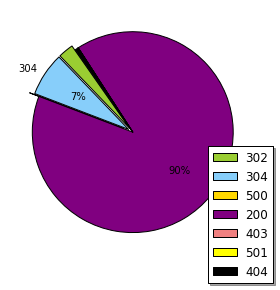

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt


def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
pass

Let us get the most frequent hosts

In [25]:
# Any hosts that has accessed the server more than 10 times.
hostCountPairTuple = access_logs.map(lambda log: (log.host, 1))

hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)

hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)

hostsPick20 = (hostMoreThan10
               .map(lambda s: s[0])
               .take(20))

print 'Any 20 hosts that have accessed more then 10 times: %s' % hostsPick20

Any 20 hosts that have accessed more then 10 times: [u'calvert.psc.rochester.edu', u'sl137.active.ch', u'slip104-134.mn.us.ibm.net', u'corning.cat.rpi.edu', u'sjackson.seanet.com', u'194.20.34.29', u'mischka.csn.tu-chemnitz.de', u'anp10.intercon.net', u'philly13.voicenet.com', u'128.158.55.143', u'pm2-01.magicnet.net', u'198.70.210.51', u'user.40.169.dcccd.edu', u'ginec01.unimo.it', u'gs1.cs.ttu.edu', u'wilma.netinfo.com.au', u'165.164.140.189', u'jabrown.remote.ualberta.ca', u'dialup96-033.swipnet.se', u'pckcb1.cad.ksc.nasa.gov']


Top 10 error endpoints

In [27]:
not200 = access_logs.filter(lambda log:log.response_code!=200)

endpointCountPairTuple = not200.map(lambda log: (log.endpoint,1))

endpointSum = endpointCountPairTuple.reduceByKey(lambda a,b: a+b)

topTenErrURLs = endpointSum.takeOrdered(10,lambda(x,v):-v)
print 'Top Ten failed URLs: %s' % topTenErrURLs

Top Ten failed URLs: [(u'/images/NASA-logosmall.gif', 21010), (u'/images/KSC-logosmall.gif', 12435), (u'/images/MOSAIC-logosmall.gif', 6628), (u'/images/USA-logosmall.gif', 6577), (u'/images/WORLD-logosmall.gif', 6413), (u'/images/ksclogo-medium.gif', 5837), (u'/images/launch-logo.gif', 4628), (u'/shuttle/countdown/liftoff.html', 3509), (u'/shuttle/countdown/', 3345), (u'/shuttle/countdown/images/cdtclock.gif', 3251)]


Let us get the number of unique hosts as well 

In [31]:
hosts=access_logs.map(lambda log:(log.host,1))
uniqueHosts=hosts.reduceByKey(lambda a,b:a+b)
print 'Total unique hosts are %d' % (uniqueHosts.count())

Total unique hosts are 81969


Let us now count the number of unique hosts on each given day

In [37]:
dayToHostPairTuple=access_logs.map(lambda log:(log.date_time.day,log.host))

dayGroupedHosts=dayToHostPairTuple.groupByKey()

dayHostCount = dayGroupedHosts.map(lambda (k, v): (k, set(v)))

dayHostCount=dayHostCount.map(lambda (x,v):(x,len(v)))


dailyHosts = (dayHostCount.sortByKey().cache())

dailyHostsList = dailyHosts.take(30)
print 'Unique hosts per day: %s' % dailyHostsList

Unique hosts per day: [(1, 5192), (2, 4859), (3, 7335), (4, 5522), (5, 7382), (6, 7819), (7, 6473), (8, 2897), (9, 2553), (10, 4464), (11, 4924), (12, 5345), (13, 6951), (14, 5296), (15, 3115), (16, 3012), (17, 4942), (18, 4522), (19, 4918), (20, 4727), (21, 4339), (22, 2575), (23, 2635), (24, 4297), (25, 4376), (26, 4296), (27, 4368), (28, 2175)]


Average number of daily requests

In [38]:
dayAndHostTuple = access_logs.map(lambda log:(log.date_time.day,log.host))

groupedByDay = dayAndHostTuple.groupByKey()


sortedByDay = groupedByDay.sortByKey()

avgDailyReqPerHost=(sortedByDay.map(lambda (x,v):(x,len(v))).
 join(dailyHosts).sortByKey().
 map(lambda (k,(v1,v2)):(k,(v1/v2)))).cache()

avgDailyReqPerHostList = avgDailyReqPerHost.take(30)
print 'Average number of daily requests per Hosts is %s' % avgDailyReqPerHostList

Average number of daily requests per Hosts is [(1, 12), (2, 12), (3, 12), (4, 12), (5, 12), (6, 12), (7, 13), (8, 13), (9, 13), (10, 16), (11, 16), (12, 17), (13, 19), (14, 15), (15, 14), (16, 15), (17, 15), (18, 14), (19, 14), (20, 14), (21, 14), (22, 13), (23, 14), (24, 14), (25, 14), (26, 13), (27, 14), (28, 12)]


Visualizing daily request

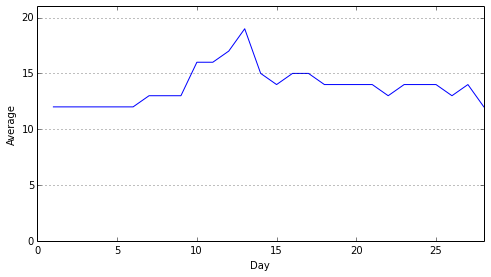

In [39]:
%matplotlib inline
daysWithAvg = avgDailyReqPerHost.map(lambda (x,v):x).collect()
avgs = avgDailyReqPerHost.map(lambda (x,v):v).collect()
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithAvg), 0, max(avgs)+2])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Average')
plt.plot(daysWithAvg, avgs)
pass